In [1]:
import warnings
# warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import tensorflow as tf

import glob
import keras
from datetime import datetime
import time
# from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import pacf
%matplotlib inline
from matplotlib.pylab import rcParams
# import seaborn as sns
rcParams['figure.figsize']=15,5

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [4]:
# seed=1226 = 0.98
seed=1226

In [5]:
from time import time

import numpy as np
import pandas as pd


# For plotting
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,7)})

#For standardising the dat
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.manifold import TSNE

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
Stations = ['Data20Nov','Data23Nov2','Data23Nov1','Data24Nov','Data24Nov2','Data25Nov','Data29Nov','Data1Dec','Data2Dec','Data3Dec']

In [7]:
#Rearrange the Array
def makeArray(Array):
    New=np.array(Array[0])

    for i in range(1,len(Array)):
        New = np.append(New,Array[i],axis=0)
        
    return New

In [8]:
def readData(Stations):
    
    Data, C = [], []
    
#     print(Stations)
    file = Stations+'.csv'
    newfile = file
    df = pd.read_csv('dataset/'+newfile, header=0, index_col=None)
    print(newfile)
    df = df.reset_index(drop=True)
    data=df[['Present_AX','Present_Ay','Present_AZ']].values
    data=data.astype('float32')
#     data=data[:,0]**2+data[:,1]**2+data[:,2]**2
#     data=np.sqrt(data)
#     data=data.reshape((-1,1))
    count=df['Change'].values
    count=count.astype('float32')
    count=count.reshape((-1,1))

#     #Normalize the data
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     data = scaler.fit_transform(data)

    Data.append(data)
    C.append(count)
           
    
        
    return makeArray(Data), makeArray(C)



In [9]:
Data=[[] for x in range(len(Stations))]
Count=[[] for x in range(len(Stations))]
for i in range(len(Stations)):
    Data[i], Count[i] = readData(Stations[i])

Data20Nov.csv
Data23Nov2.csv
Data23Nov1.csv
Data24Nov.csv
Data24Nov2.csv
Data25Nov.csv
Data29Nov.csv
Data1Dec.csv
Data2Dec.csv
Data3Dec.csv


In [10]:
for i in range(10):
    print(Data[i].shape)

(28699, 3)
(44972, 3)
(13357, 3)
(9227, 3)
(18083, 3)
(12494, 3)
(16510, 3)
(3161, 3)
(3567, 3)
(1772, 3)


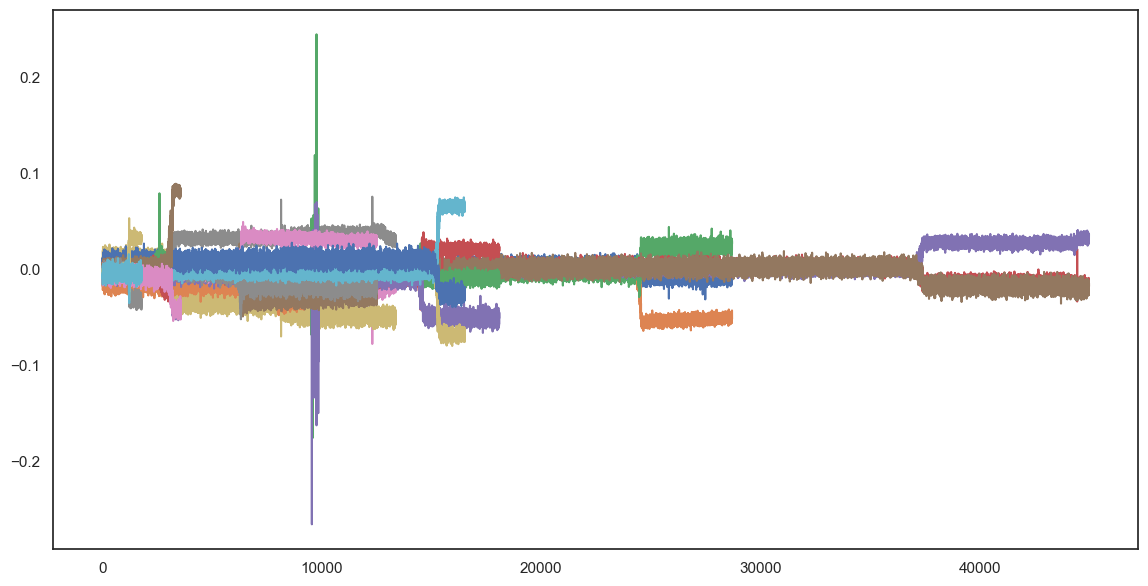

In [11]:
for i in range(10):
    plt.plot(Data[i])


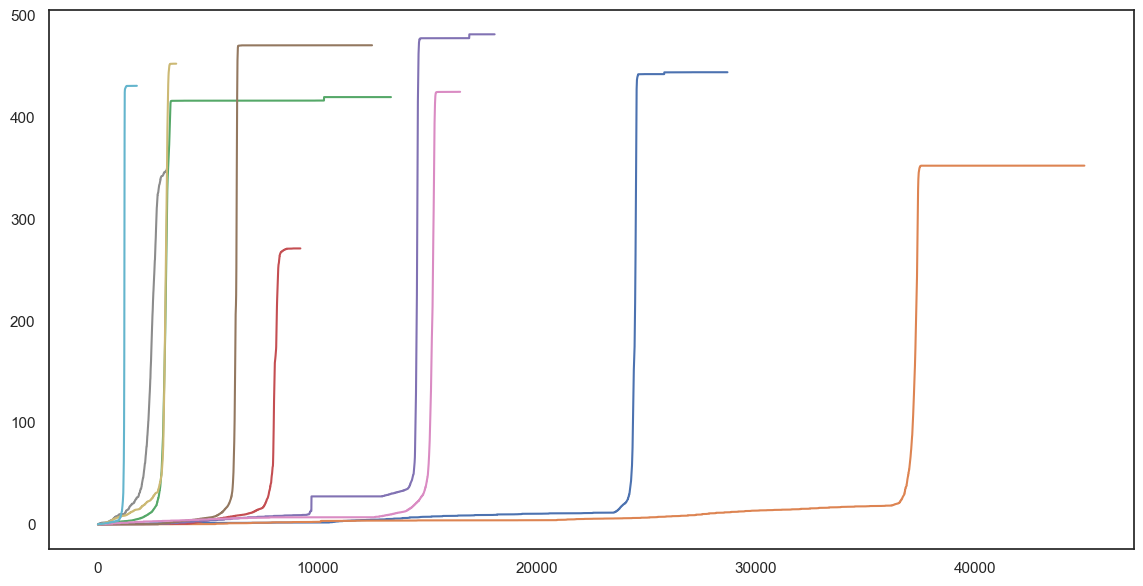

In [12]:
for i in range(10):
    plt.plot(np.cumsum(Count[i]))


In [13]:
def makePacket(data,label,lag):
    D,L=[],[]
    length=len(data)
    for i in range(length-lag+1):
        D.append(data[i:lag+i,:])
        L.append(label[lag+i-1]-label[i])
        
    return np.array(D),np.array(L)
        
   

In [14]:
DD=np.zeros(10)
LL=np.zeros(10)
for i in range(10):
    DD[i]=i
    LL[i]=i
DD=DD.reshape((-1,1))   
LL=LL.reshape((-1,1))  

In [15]:
D,L=makePacket(Data[0],Count[0],3)

In [16]:
D.shape

(28697, 3, 3)

In [17]:
L

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [18]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

Metal device set to: Apple M1 Pro
(2048, 512)


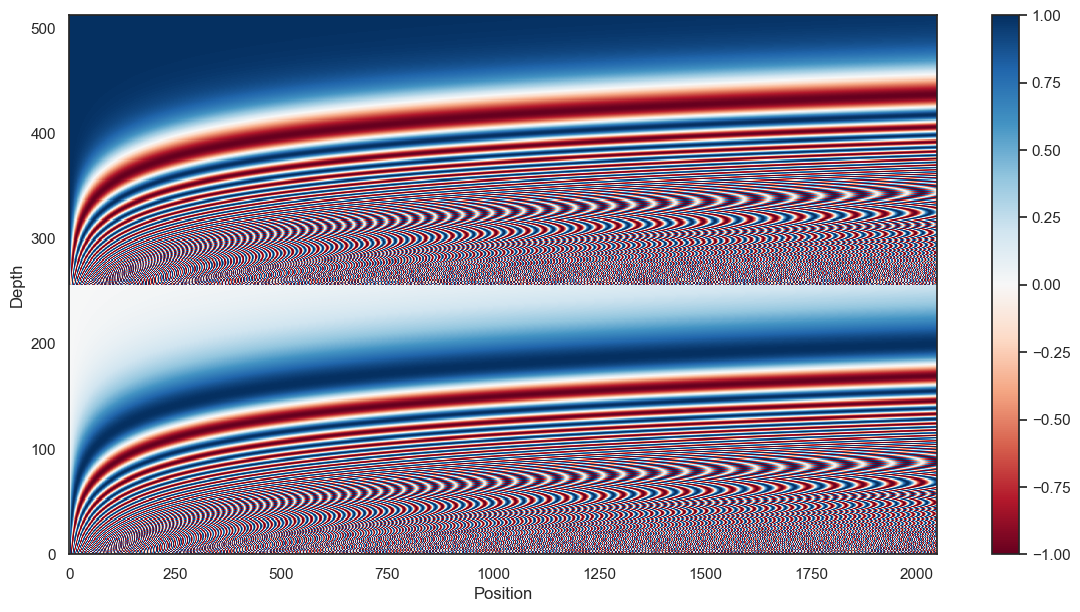

In [19]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

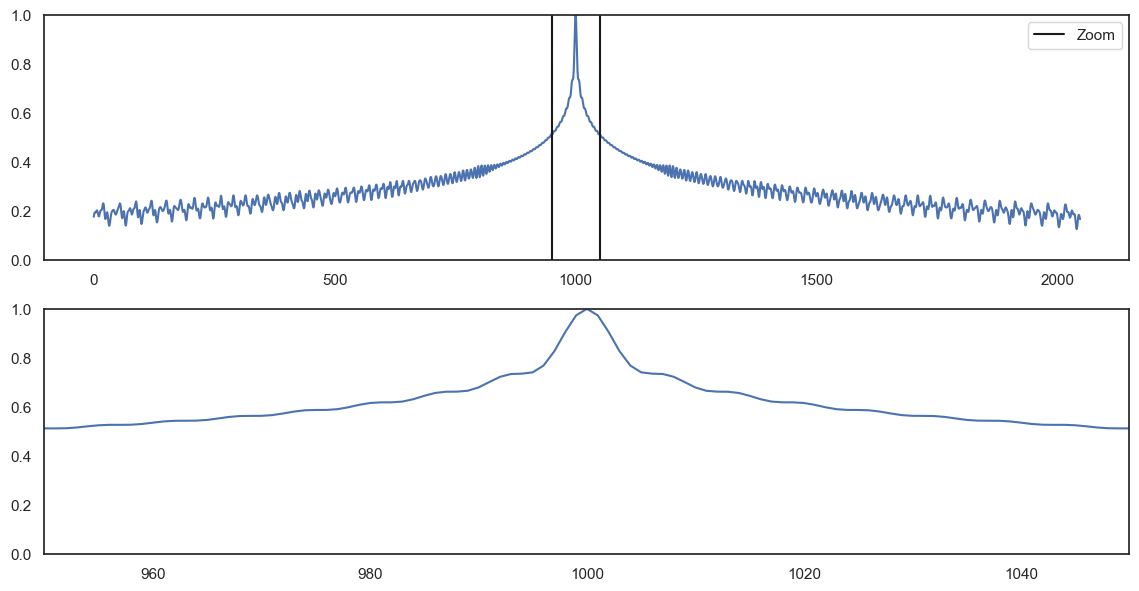

In [20]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


In [50]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x


In [51]:
en=Data[9]
pt=Count[9]

In [52]:
en.shape

(1772, 3)

In [53]:
embed_pt = PositionalEmbedding(vocab_size=1000, d_model=512)
embed_en = PositionalEmbedding(vocab_size=1000, d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [54]:
pt_emb.shape

TensorShape([1772, 1, 512])

In [341]:
en_emb.shape

TensorShape([1772, 3, 512])

In [55]:
def pos(en,ln, sh):
    N=np.zeros((ln,512-sh))
    M=np.hstack((en,N))
    M *= tf.math.sqrt(tf.cast(512, tf.float32))
    P=positional_encoding(length=2048, depth=512)
    M = M + P[ :ln, :]
    return M

In [56]:
M=pos(en,1772,3)
N=pos(pt,1772,1)

In [57]:
M.shape

TensorShape([1772, 512])

In [58]:
N.shape

TensorShape([1772, 512])

In [59]:
# en_emb._keras_mask

In [60]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [61]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [62]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
#         print(x)
        attn_output = self.mha(query=x, value=x,key=x)
#         print(attn_output)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [63]:
# gsa=GlobalSelfAttention(num_heads=8,key_dim=128)

In [64]:
# gsa(pt_emb)

In [65]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            )
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [66]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x


In [67]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [269]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

#         Add dropout.
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [270]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [271]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [374]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='relu')

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs
        
        
        
        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
        print(logits)
        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [375]:
num_layers = 4
d_model = 4
dff = 50
num_heads = 1
dropout_rate = 0.1

In [376]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=350,
    target_vocab_size=1,
    dropout_rate=dropout_rate)

In [377]:
en_emb.shape

TensorShape([1772, 3, 512])

In [378]:
pt_emb.shape

TensorShape([1772, 1, 512])

In [379]:
A=en[:100]
B=pt[:100]

In [380]:
A.shape, B.shape

((100, 3), (100, 1))

In [381]:
output = transformer((A, B))

print(en.shape)
print(pt.shape)
print(output.shape)

tf.Tensor(
[[[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[0.]]], shape=(100, 1, 1), dtype=float32)
(1772, 3)
(1772, 1)
(100, 1, 1)


In [382]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [383]:
learning_rate = CustomSchedule(d_model)
# learning_rate = 0.5
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

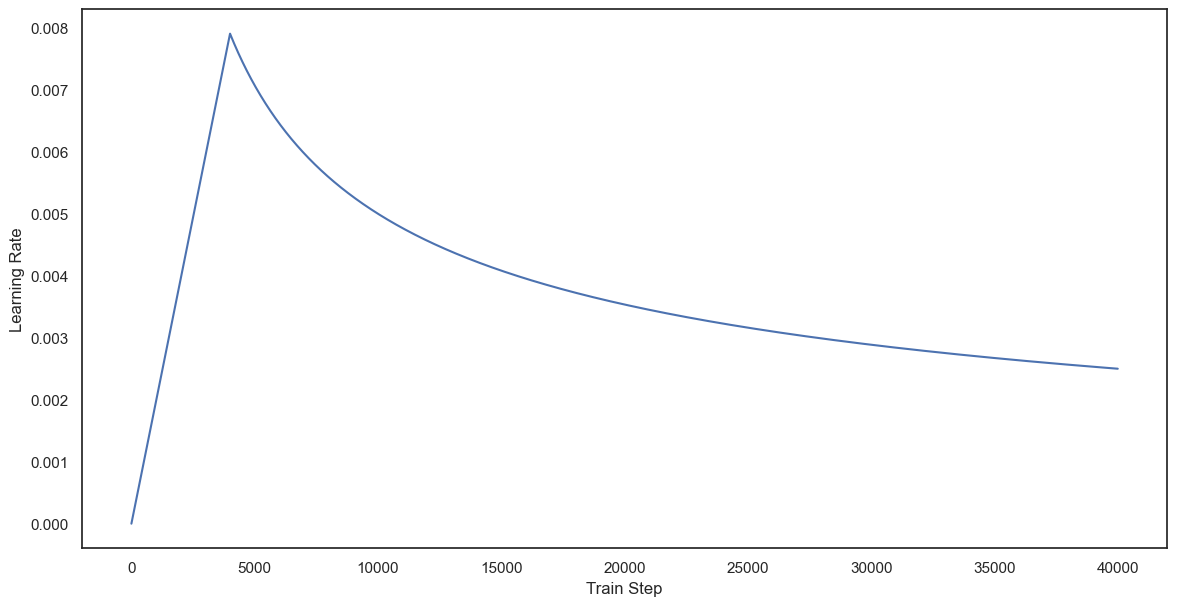

In [384]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [385]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [386]:
def custom_loss_function(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [387]:
transformer.compile(loss=custom_loss_function, optimizer=optimizer)

In [388]:
transformer.summary()

Model: "transformer_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_10 (Encoder)        multiple                  3600      
                                                                 
 decoder_10 (Decoder)        multiple                  2556      
                                                                 
 dense_188 (Dense)           multiple                  5         
                                                                 
Total params: 6,161
Trainable params: 6,161
Non-trainable params: 0
_________________________________________________________________


In [389]:
D=Data[9][1:]-Data[9][:-1]

In [390]:
D[:,0]

array([-0.0056,  0.0037,  0.    , ...,  0.0088, -0.0029, -0.0027],
      dtype=float32)

In [391]:
D[np.where((D[:,0]<0.02) & (D[:,0]>-0.02)),0]=0
D[np.where((D[:,1]<0.02) & (D[:,1]>-0.02)),1]=0
D[np.where((D[:,2]<0.02) & (D[:,2]>-0.02)),2]=0

In [392]:
np.where(D[:,0]<0.02)

(array([   0,    1,    2, ..., 1768, 1769, 1770]),)

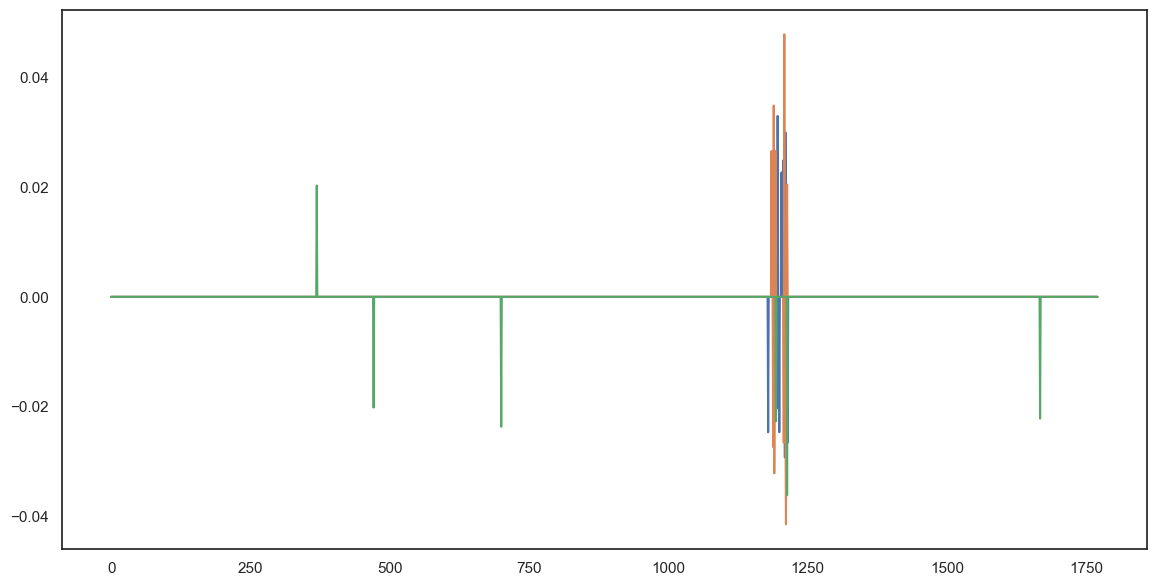

In [393]:

plt.plot(D)

In [394]:
S=Count[9][1:]

In [395]:
Inp1=[]
Inp2=[]
Vald1=[]
Vald2=[]
for i in range(1):
    Inp1.append(Data[9])
    Inp2.append(Count[9])
    
Vald1.append(Data[8])
Vald1.append(Data[9])
Vald2.append(Count[8])
Vald2.append(Count[9])

Inp1=np.array(Inp1)
Inp2=np.array(Inp2)
Vald1=np.array(Vald1)
Vald2=np.array(Vald2)
Inp1=np.vstack(Inp1)
Inp2=np.vstack(Inp2)
Vald1=np.vstack(Vald1)
Vald2=np.vstack(Vald2)

In [396]:
Inp1.shape

(1772, 3)

In [397]:
Input=(Inp1,Inp2)
Val  =(Vald1,Vald2)

In [398]:
Inp1.shape

(1772, 3)

In [399]:
callbacks = [keras.callbacks.EarlyStopping(monitor='loss',patience=10, restore_best_weights=True)]

In [400]:
transformer.fit(Input,Inp2,epochs=20,batch_size=2048, callbacks=callbacks)

Epoch 1/20
Tensor("transformer_10/dense_188/Relu:0", shape=(None, 1, 1), dtype=float32)
Tensor("transformer_10/dense_188/Relu:0", shape=(None, 1, 1), dtype=float32)
1/1 [==============================] - 11s 11s/step - loss: 2.7989
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 2.8257
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 2.8162
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 2.8052
Epoch 5/20
1/1 [==============================] - 1s 930ms/step - loss: 2.8336
Epoch 6/20
1/1 [==============================] - 1s 972ms/step - loss: 2.7478
Epoch 7/20
1/1 [==============================] - 1s 952ms/step - loss: 2.8080
Epoch 8/20
1/1 [==============================] - 1s 999ms/step - loss: 2.7783
Epoch 9/20
1/1 [==============================] - 1s 663ms/step - loss: 2.8288
Epoch 10/20
1/1 [==============================] - 1s 587ms/step - loss: 2.8223
Epoch 11/20
1/1 [==============================] - 1s 595ms/step 

In [401]:
Pre = transformer([Inp1, Inp2], training=False)

tf.Tensor(
[[[0.]]

 [[0.]]

 [[0.]]

 ...

 [[0.]]

 [[0.]]

 [[0.]]], shape=(1772, 1, 1), dtype=float32)


In [402]:
Pre=Pre.numpy()

In [403]:
Pre=Pre.reshape((-1,1))

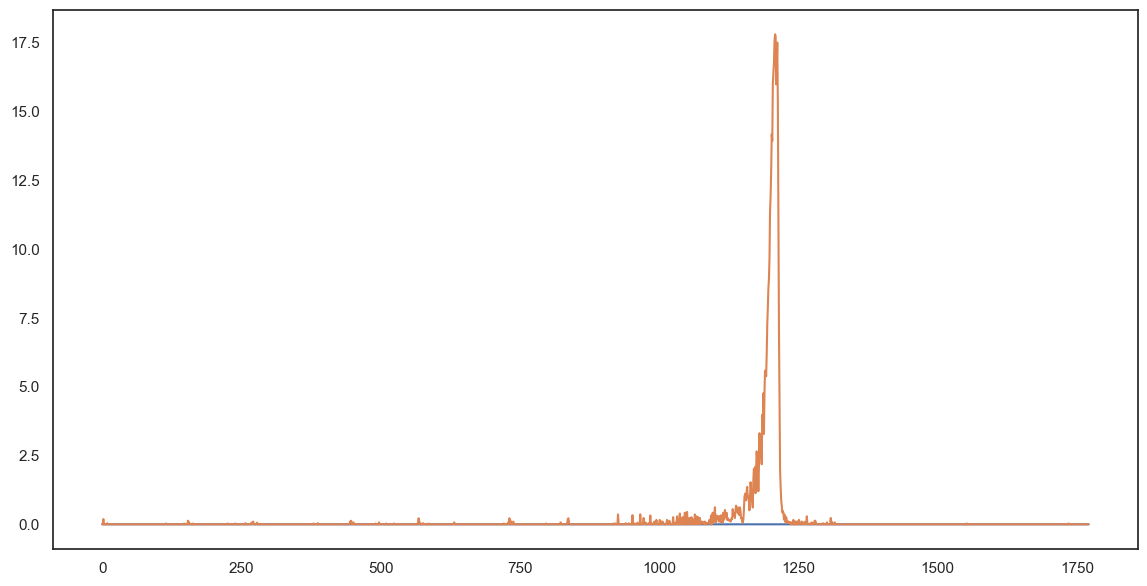

In [404]:
plt.plot(Pre)
plt.plot(Input[1])

In [323]:
Pre

array([[0.04951522],
       [0.04951522],
       [0.04951522],
       ...,
       [0.04951522],
       [0.04951522],
       [0.04951522]], dtype=float32)

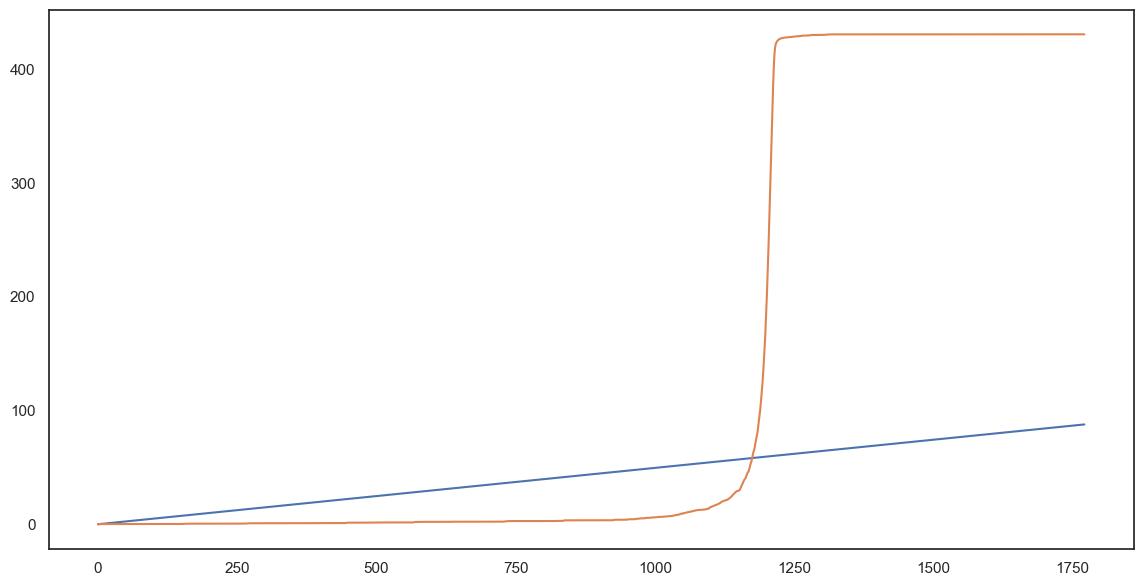

In [324]:
plt.plot(np.cumsum(Pre))
plt.plot(np.cumsum(Input[1]))

In [130]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))



In [ ]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [ ]:
# XX=x_train
# YY=y_train


In [ ]:
C=Count[0]

In [ ]:
y_train.shape

In [ ]:
Y=Count[0]

In [ ]:
XX.shape

In [ ]:
X=Data[0].reshape((28699,1,1))

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='loss',patience=10, restore_best_weights=True)]



In [ ]:
model.fit(
    X,
    Y,
    
    epochs=500,
    batch_size=512,
    callbacks=callbacks
)

# model.evaluate(x_test, y_test, verbose=1)

In [ ]:
P=model.predict(X)

In [ ]:
plt.plot(P)
plt.plot(Y)

In [ ]:
def readData2(Stations):
    
    Data, C = [], []
    
#     print(Stations)
    file = Stations+'.csv'
    newfile = file
    df = pd.read_csv('dataset/'+newfile, header=0, index_col=None)
    print(newfile)
    df = df.reset_index(drop=True)
    data=df[['Present_AX','Present_Ay','Present_AZ']].values
    data=data.astype('float32')
#     data=data[:,0]**2+data[:,1]**2+data[:,2]**2
#     data=np.sqrt(data)
#     data=data.reshape((-1,1))
    count=df['Corrected'].values
    count=count.astype('float32')
    count=count.reshape((-1,1))

#     #Normalize the data
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     data = scaler.fit_transform(data)

    Data.append(data)
    C.append(count)
           
    
        
    return makeArray(Data), makeArray(C)



In [ ]:
Data=[[] for x in range(len(Stations))]
Count=[[] for x in range(len(Stations))]
for i in range(len(Stations)):
    Data[i], Count[i] = readData2(Stations[i])

In [ ]:
Data[0]

In [ ]:
Count[0]

In [ ]:
def makePacket(data,label,lag):
    D,L=[],[]
    length=len(data)
    for i in range(length-lag+1):
        D.append(data[i:lag+i,:])
        L.append(label[lag+i-1]-label[i])
        
    return np.array(D),np.array(L)
        

In [ ]:
lag=20

In [ ]:
D,L=makePacket(Data[0],Count[0],lag)

In [ ]:
L

In [ ]:
D=D[:28600]
L=L[:28600]

In [ ]:
plt.plot(L)

In [ ]:
D.shape

In [ ]:
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense,Input,Reshape, Flatten,ELU,RepeatVector,TimeDistributed
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K

In [ ]:
# define encoder
visible = Input(shape=(lag,3))
encoder = LSTM(100, activation='relu')(visible)
decoder2 = TimeDistributed(Dense(100))(encoder)
decoder2 = Flatten()(decoder2)
decoder2 = Dense(1,activation='relu',name='output')(decoder2)

# tie it together
final = Model(inputs=visible, outputs=decoder2)

In [ ]:
tf.random.set_seed(seed)
np.random.seed(seed)

callbacks = [keras.callbacks.EarlyStopping(monitor='loss',patience=10, restore_best_weights=True)]
final.compile(optimizer='adam', loss='mse')
final.fit(D,L, epochs=500, batch_size=512,  verbose=1, shuffle=True,callbacks=callbacks)

In [ ]:
P=final.predict(D)

In [ ]:
plt.plot(np.cumsum(P))
# plt.plot(np.cumsum(L),color='r')
plt.plot(Count[0],color='g')

In [ ]:
plt.plot(P)